# MMIS692 Quality Control

Items are produced in batches. A batch with more than 1 defective item is deemed a *poor* quality batch.

We shall develop a model to predict batch quality based on measurements from the 30 quality control tests. Our goal is to predict quality reliably based on as few rules as possible. Any test that is not used for determining batch quality may be eliminated, thereby reducing quality control costs.

For this classification task we shall use *Scikit-Learn* *DecisionTreeClassifier*:
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

## Import libraries

In [1]:
# ! pip install pandasql # to use SQL
import pandasql # for SQL queries
import pandas as pd # for data analysis
from sklearn.tree import DecisionTreeClassifier, plot_tree # for decision tree
from sklearn.model_selection import cross_val_score # for cross validation
from sklearn.metrics import accuracy_score, confusion_matrix # to evaluate model
import matplotlib.pyplot as plt # for plots

## Get data

We shall extract *CSV* files from the *zip* file with data and read the data we need for this task into *pandas* dataframes:
- ***defective***: with data from '*quality_control.defective.csv*'
- ***measurements***: with data from '*quality_control.measurements.csv*'
- ***new_batches***: with data from '*quality_control.new_batches.csv*'

In [2]:
# ! unzip '/content/drive/MyDrive/Colab Notebooks/courses/MMIS692_Summer2021/data.MMIS692.Sample.zip'
import zipfile as zf

files = zf.ZipFile('data.MMIS692.Sample.zip', 'r')
files.extractall()
files.close()

defective = pd.read_csv('quality_control.defective.csv')
measurements = pd.read_csv('quality_control.measurements.csv')
new_batches = pd.read_csv('quality_control.new_batches.csv')
# !rm *.csv

Dataframe *defective* contains the *batchID* of batches in which defective items were produced.

In [3]:
print("Dataframe defective contains %d rows and %d columns" %defective.shape)
defective.head(10) # display first 10 rows of defective

Dataframe defective contains 12476 rows and 2 columns


,serial_nbr,batchID
0,S008B017905,B017905
1,S003B047981,B047981
2,S003B047081,B047081
3,S006B030185,B030185
4,S000B018620,B018620
5,S006B017504,B017504
6,S002B018949,B018949
7,S002B006554,B006554
8,S003B048799,B048799
9,S000B043870,B043870


Dataframe measurements contains measurements on 30 quality control tests for each batch

In [4]:
print("Dataframe measurements contains %d rows and %d columns" %measurements.shape)
measurements.head() # display first 5 rows of measurements

Dataframe measurements contains 5000 rows and 31 columns


,batchID,test1,test2,test3,test4,test5,test6,test7,test8,test9,...,test21,test22,test23,test24,test25,test26,test27,test28,test29,test30
0,B028174,101,724,230,674,190,433,172,80,755,...,656,457,312,850,961,510,84,755,44,3
1,B032782,842,881,312,163,230,773,198,691,105,...,894,391,632,656,792,588,908,7,672,394
2,B008211,865,935,715,249,207,263,794,104,416,...,263,141,173,440,114,67,650,342,773,252
3,B013581,920,369,966,574,170,579,850,280,880,...,424,0,631,247,912,875,570,767,669,770
4,B009542,721,359,428,907,177,18,918,932,550,...,800,396,813,145,378,706,190,114,584,690


## Label batches
We consider a batch to be of *poor* quality if it contains more than one defective item; otherwise, the batch quality is considered *good*. 

The dataframe *defective* contains *batchID* for batches in which defective items were produced.

We shall identify batches with more than one defective items using *SQL* and *pandas*, and confirm that the set of poor quality batches found using both methods are identical.

We shall then label each batch in the dataframe *measurements* as either a *poor* quality batch or a *good* quality batch.   




### Using SQL

**SQL** queries may be executed using *pandasql*; each dataframe is a table.

In [5]:
# define a string q with the SQL query to identify poor quality bacthers
q = """
select batchID  
from defective
group by batchID 
having count(*) > 1;
"""

poor_batches_SQL = pandasql.sqldf(q).values # evaluate query to get poor quality batches

print("Number of poor quality batches = %d" %len(poor_batches_SQL))
print("Proportion of poor quality batches = %4.4f" %(len(poor_batches_SQL)/len(measurements)))

# assign labels to each batch in the dataframe measurements
labels = ['poor' if b in poor_batches_SQL else 'good' 
          for b in measurements.batchID] # assign labels for batches

# create dataframe with quality of batches labeled 'poor' or 'good'
quality_SQL = pd.DataFrame(zip(measurements.batchID, labels), columns=['batchID', 'quality'])
quality_SQL.head(10).to_csv('quality_SQL.csv', index=False) # save results for first 10 batches
print("Quality of first 10 batches")
quality_SQL.head(10)

Number of poor quality batches = 2478
Proportion of poor quality batches = 0.4956
Quality of first 10 batches


,batchID,quality
0,B028174,poor
1,B032782,good
2,B008211,poor
3,B013581,poor
4,B009542,good
5,B021807,good
6,B003282,good
7,B036304,poor
8,B028520,good
9,B022785,poor


### Using pandas

In [6]:
g = defective.groupby('batchID') # group defective items by batches
poor_batches = g.filter(lambda x: len(x)>1).batchID.unique() # batches with more than 1 defective items

print("Number of poor quality batches = %d" %len(poor_batches))
print("Proportion of poor quality batches = %4.4f" %(len(poor_batches)/len(measurements)))

labels = ['poor' if b in poor_batches else 'good' for b in measurements.batchID] # labels for batches

# create dataframe with quality of batches labeled 'poor' or 'good'
quality = pd.DataFrame(zip(measurements.batchID, labels), columns=['batchID', 'quality'])
quality.head(10).to_csv('quality.csv', index=False)
print("Quality of first 10 batches")
quality.head(10)

Number of poor quality batches = 2478
Proportion of poor quality batches = 0.4956
Quality of first 10 batches


,batchID,quality
0,B028174,poor
1,B032782,good
2,B008211,poor
3,B013581,poor
4,B009542,good
5,B021807,good
6,B003282,good
7,B036304,poor
8,B028520,good
9,B022785,poor


### Confirm that quality results are identical

In [7]:
all(quality==quality_SQL)

True

## Reserve data for validation

We shall use the first 4000 samples for training and reserve the last 1000 samples for validation.

*X_train*, *y_train*: contain input feature values and output labels for training data.

*X_test*, *y_test*: contain input feature values and output labels for validation data.

In [8]:
# all but the first column in dataframe measurements are input features
features = list(measurements)[1:] # column headers for input features
print("Number of input features = %d" %len(features))
print(', '.join(features)) # display features

k = 4000 # use first k samples for training
print("First %d samples used for training" %k)
X_train, y_train = measurements[features][:k], quality.quality[:k] # input, label for training
X_test, y_test = measurements[features][k:], quality.quality[k:] # input, label for validation

Number of input features = 30
test1, test2, test3, test4, test5, test6, test7, test8, test9, test10, test11, test12, test13, test14, test15, test16, test17, test18, test19, test20, test21, test22, test23, test24, test25, test26, test27, test28, test29, test30
First 4000 samples used for training


## Cross validation accuracy

We shall use *Scikit-Learn* *DecisionTreeClassifier* to predict batch quality based on measurements from the 30 tests.

Since our goal is to achieve satisfactory classification using as few rules as possible, we shall investigate how classification accuracy varies as we increase the maximum number of leaf nodes (rules)in the decision tree. 

We shall use 5-fold cross-validation with the training samples for this investigation.

In [9]:
for k in range(2, 10): # maximum number of leaf-nodes (rules)
    model = DecisionTreeClassifier(max_leaf_nodes=k) # tree with k rules
    acc = cross_val_score(model, X_train, y_train).mean() # mean accuracy in 5-fold cross-validation
    print("Cross validation accuracy with %d rules = %4.4f" %(k, acc))

Cross validation accuracy with 2 rules = 0.6980
Cross validation accuracy with 3 rules = 0.8678
Cross validation accuracy with 4 rules = 0.9795
Cross validation accuracy with 5 rules = 0.9793
Cross validation accuracy with 6 rules = 0.9783
Cross validation accuracy with 7 rules = 0.9780
Cross validation accuracy with 8 rules = 0.9778
Cross validation accuracy with 9 rules = 0.9768


## Choose a good model

Choose the number of rules that results in satisfactory cross-validation accuracy

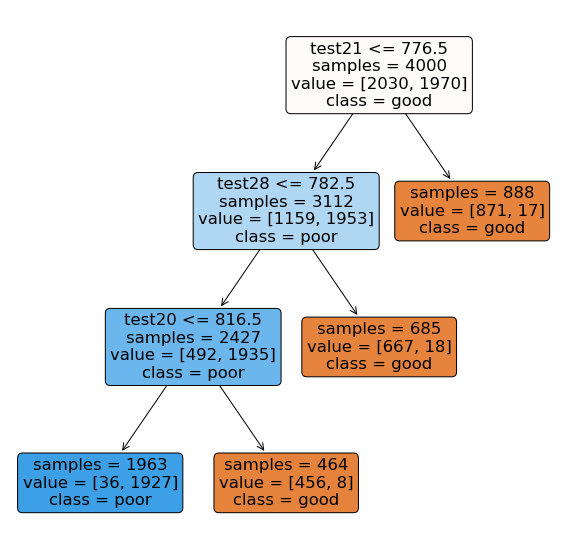

In [10]:
k = 4 # chosen number of leaf nodes
model = DecisionTreeClassifier(max_leaf_nodes=k) # create model
model.fit(X_train, y_train) # train model 

plt.figure(figsize=(10, 10)) # size of figure to be displayed

CL = model.classes_ # class labels (good / poor)
plot_tree(model, feature_names=features, class_names=CL, 
          filled=True, rounded=True, impurity=False) # plot tree

plt.savefig("decision_tree.png") # save as PNG file
plt.show() # show tree

## Results with training data

In [11]:
pred_train = model.predict(X_train) # predicted labels for training samples
acc_train = accuracy_score(y_train, pred_train) # training accuracy
print("Training accuracy  = %4.4f" %(acc_train))
# confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, pred_train), columns=[f'Predicted {c}' for c in CL], index=CL)
cm.to_csv('training_confusion_matrix.csv') # save confusion matrix
cm

Training accuracy  = 0.9802


,Predicted good,Predicted poor
good,1994,36
poor,43,1927


## Results with validation data

In [12]:
pred_test = model.predict(X_test) # predicted labels for validation samples
acc_test = accuracy_score(y_test, pred_test) # validation accuracy
print("Validation accuracy  = %4.4f" %(acc_test))
cm = pd.DataFrame(confusion_matrix(y_test, pred_test), columns=[f'Predicted {c}' for c in CL], index=CL)
cm.to_csv('validation_confusion_matrix.csv')
cm

Validation accuracy  = 1.0000


,Predicted good,Predicted poor
good,492,0
poor,0,508


## Predict quality for unlabeled samples

In [13]:
new_labels = pd.DataFrame()
new_labels['batchID'] = new_batches.batchID
new_labels['quality'] = model.predict(new_batches[features])
new_labels.to_csv("new_labels.csv", index=False)
new_labels

,batchID,quality
0,B040188,good
1,B025510,good
2,B041196,good
3,B042534,good
4,B028581,good
5,B043338,good
6,B008259,good
7,B049978,good
8,B037925,good
9,B007727,good
